In [302]:
import random
import string
import numpy as np

import torch
import torch.nn.functional as F
from torch import Tensor

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from dataclasses import dataclass, field

torch.set_printoptions(linewidth=120)
seed = 2**31 - 1

<hr>

# Backpropagation
<hr>

In this notebook, we will write the backpropagation manually. It is valuable exercise for gaining a deeper understanding of the algorithm. Although in practice, we typically do not implement backpropagation manually, it is crucial to comprehend the process that occurs beneath the surface.   

One challenge with backpropagation is that it represents a [leaky abstraction](https://www.wikiwand.com/en/Leaky_abstraction). Understanding of the algorithm can avoid numerous errors and improve the ability to debug issues that may arise.

## Setup

**Load the data**

In [303]:
# Load the data
with open('./data/names.txt', 'r') as f:
    names = f.read().splitlines()
print(f'Total # names: {len(names):.>25,}')
print(f"Total # characters in all names: {len(''.join(names)):,}")
print(names[:5])

Total # names: ...................32,033
Total # characters in all names: 196,113
['emma', 'olivia', 'ava', 'isabella', 'sophia']


**Encoding and decoding characters**   
We define an encoder `ch2ix` and decoder `ix2ch` function that maps a character with a numerical representation (i.e. a unique integer) and vice-versa. 

In [304]:
chars = '.' + string.ascii_lowercase
ch2ix = {s: i for i, s in enumerate(chars)}
ix2ch = {i: s for s, i in ch2ix.items()}

print('Encoder ch2ix:\n', ch2ix)
print('Decoder ix2ch:\n', ix2ch)
print('E.g. emma:', [ch2ix[c] for c in '.emma.'])

vocab_size = len(chars)
print(f'Vocab size: {vocab_size:,}')

Encoder ch2ix:
 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
Decoder ix2ch:
 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
E.g. emma: [0, 5, 13, 13, 1, 0]
Vocab size: 27


**Dataset**

In [305]:
@dataclass
class Dataset:
    """
    Attributes:
    names: list of names.
    block_size: context length: how many characters do we take to predict the next one?
    """

    names: list[str]
    block_size: int = 3
    verbose: bool = False
    X: Tensor = field(init=False)
    Y: Tensor = field(init=False)

    def __post_init__(self) -> None:
        self._make_dataset()

    def _make_dataset(self) -> None:
        X, Y = [], []
        for w in self.names:
            if self.verbose:
                print(w)
            context = [0] * self.block_size
            for ch in w + '.':
                ix = ch2ix[ch]
                X.append(context)
                Y.append(ix)
                if self.verbose:
                    print(''.join(ix2ch[i] for i in context), '--->', ix2ch[ix])
                context = context[1:] + [ix]  # crop and append
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y)
        print(f'X.shape: {self.X.shape}, Y.shape: {self.Y.shape}')


In [306]:
# Create a training, validation and test set
block_size = 3
np.random.seed(42)
np.random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

ds_tr = Dataset(names[:n1], block_size=block_size)
Xtr, Ytr = ds_tr.X, ds_tr.Y  # 80%
ds_val = Dataset(names[n1:n2], block_size=block_size)
Xval, Yval = ds_val.X, ds_val.Y  # 10%
ds_te = Dataset(names[n2:], block_size=block_size)
Xte, Yte = ds_te.X, ds_te.Y  # 10%

X.shape: torch.Size([182671, 3]), Y.shape: torch.Size([182671])
X.shape: torch.Size([22784, 3]), Y.shape: torch.Size([22784])
X.shape: torch.Size([22691, 3]), Y.shape: torch.Size([22691])


**Utility functions**

In [307]:
def compare_gradients(description, manual_grads, autograd_grads):
    exact_match = torch.all(manual_grads == autograd_grads.grad).item()
    approx_match = torch.allclose(manual_grads, autograd_grads.grad)
    max_difference = (manual_grads - autograd_grads.grad).abs().max().item()
    print(f'{description:15s} | exact: {str(exact_match):5s} | approximate: {str(approx_match):5s} | maxdiff: {max_difference}')


## Model

We initialise a MLP model with 64 hidden units and an character embedding dimension of 10. 


```{note}
Because we have a batch norm layer, we do not need to add a bias term to the linear layers. We define them anyway because it's still interesting to calculate the gradients.
```
Normally we should initialise the weights and biases as follows:   
- gain = 5/3 for tanh   
- $W_1: \large\frac{5/3}{\sqrt{\text{fan}_{\text{in}}}}$    
- $b_1: 0$   
- $W_2: \large\frac{5/3}{\sqrt{\text{fan}_{\text{in}}}}$   
- $b_2: 0$   

However, we will initialise the weights and biases in non-standard ways because sometimes initializating with e.g. all zeros could mask an incorrect implementation of the backward pass. 


In [308]:
n_emb = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(seed)  # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)

# Layer 1
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5 / 3) / ((n_emb * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
bn_gain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bn_bias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
n_params = sum(p.nelement() for p in parameters)
print(f'Total # parameters: {n_params:,}')
for p in parameters:
    p.requires_grad = True


Total # parameters: 4,137


## Forward pass

**Calculate a single batch**

In [309]:
bs = 32
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (bs,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # batch

**Calculate a forward pass on the batch**

We will make the forward pass with the smallest steps possible. This will make it easier to understand the backward pass.

Batch norm calculation:
- emb_cat is a 32x30 tensor (batch size x sequence length)
- $\textrm{h\_pre\_bn} = \textrm{emb\_cat} \cdot W_1 + b_1$
- $\textrm{bn\_mean\_i} = \sum_{i=1}^{32}{h\_pre\_bn}_i$
- $\textrm{bn\_diff} = \textrm{h\_pre\_bn} - \textrm{bn\_mean\_i}$
- $\textrm{bn\_diff2}= \textrm{bn\_diff}^2$
- $\textrm{bn\_var} = \sum_{i=1}^{32}\textrm{bn\_diff2}$
- $\textrm{bn\_var\_inv} = \frac{1}{\sqrt{(\textrm{bn\_var} + \epsilon)}}$
- $\textrm{bn\_raw} = \textrm{bn\_diff} * \textrm{bn\_var\_inv}$
- $\textrm{h\_pre\_act} = \textrm{bn\_gain} * \textrm{bn\_raw} + \textrm{bn\_bias}$

In [310]:
# Embed the characters into vectors and concatenate them
emb = C[Xb]  # 32 x 3 x 10
emb_cat = emb.view(emb.shape[0], -1)  # 32 x 30

# Linear layer 1
# pre-batch norm
h_pre_bn = emb_cat @ W1 + b1  # 32 x 64
# batch norm layer
bn_mean_i = h_pre_bn.sum(0, keepdim=True) / bs  # 1 x 64 (keepdim=True to keep the 1 x 64 shape otherwise 64)
bn_diff = h_pre_bn - bn_mean_i  # 32 x 64
bn_diff2 = bn_diff**2  # 32 x 64
bn_var = bn_diff2.sum(0, keepdim=True) / (bs - 1)  # 1 x 64  Bessel's correction (dividing by n-1, not n)
bn_var_inv = (bn_var + 1e-5) ** -0.5  # 1 x 64
bn_raw = bn_diff * bn_var_inv  # 32 x 64 batchnorm raw output
h_pre_act = bn_gain * bn_raw + bn_bias  # 32 x 64 hiodden layer pre-activation
# non-linearity
h = torch.tanh(h_pre_act)  # 32 x 64

# Linear layer 2
# output layer
logits = h @ W2 + b2  # 32 x 28

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values  # 32 x 1
norm_logits = logits - logit_maxes  # 32 x 27 subtract max for numerical stability
counts = norm_logits.exp()  # 32 x 27
counts_sum = counts.sum(1, keepdims=True)  # 32 x 1
counts_sum_inv = counts_sum**-1  # 32 x 1
probs = counts * counts_sum_inv  # 32 x 27
logprobs = probs.log()  # 32 x 27
loss = -logprobs[range(bs), Yb].mean()


## Backward pass

### Pytorch backward pass

We will first calculate the backward pass with Pytorch's autograd. This will allow us to compare the results of our manual implementation with the Pytorch implementation.

In [311]:
# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,
    norm_logits,
    logit_maxes,
    logits,
    h,
    h_pre_act,
    bn_raw,
    bn_var_inv,
    bn_var,
    bn_diff2,
    bn_diff,
    h_pre_bn,
    bn_mean_i,
    emb_cat,
    emb,
]:
    t.retain_grad()
loss.backward()
loss

tensor(3.4002, grad_fn=<NegBackward0>)

### Manual backward pass

#### Cross entropy loss

We now calculate the backward pass of each step manually. We will compare the results with the Pytorch implementation.

```{note}
The shape of the gradient should be the same as the shape of its parameter
```

**logprobs** 
```python
loss = -logprobs[range(bs), Yb].mean()
```


```python 
logprobs[range(bs), Yb]
``` 
plucks the `logprob` corresponding to the value of the element of `Yb` for each sample in the batch.


The derivative of `loss` with respect to the `logprobs` is 0 everywhere except for the `logprob` corresponding to the value of the elements of `Yb` where it is $-\large\frac{1}{bs}$. 


In [312]:
d_logprobs = torch.zeros_like(logprobs)  # 32 x 27
d_logprobs[range(bs), Yb] = -1.0 / bs

compare_gradients('logprobs', d_logprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


**probs**

```python
logprobs = probs.log()
```
All the elements of `probs` are loged element-wise. The derivative of a log is ${\large\frac{d}{dx}} log(x) = \large\frac{1}{x}$.

The derivative of `logprobs` with respect to `probs` is thus (chain rule) ${\large\frac{1}{probs}} * \textrm{d\_logprobs}$.   


Intuitively, if an element of `probs` is close to 1, the network correctly predicts the next character.  The `d_logprobs` is just passed through.  
However, when an element of `probs` is small, 1/probs is big and amplifies `d_logprobs`.

`probs` and `d_logprobs` are both 32x27 tensors and therfore can be multiplied without broadcasting.

In [313]:
d_probs = (1.0 / probs) * d_logprobs  # 32 x 27

compare_gradients('probs', d_probs, probs)


probs           | exact: True  | approximate: True  | maxdiff: 0.0


**d_counts_sum_inv**

```python
probs = counts * counts_sum_inv
```


---
Toy example:   
Broadcasting a 3x1 tensor to a 3x3 tensor

\begin{align*}
  c &= a * b\\
  c[3\text{x}3] &= a[3\text{x}3] * b[3\text{x}1]\\
  \begin{bmatrix}
    c_{11} & c_{12} & c_{13}\\
    c_{21} & c_{22} & c_{23}\\
    c_{31} & c_{32} & c_{33}
  \end{bmatrix} &=
  \begin{bmatrix}
    a_{11}*b_1 & a_{12}*b_1 & a_{13}*b_1\\
    a_{21}*b_2 & a_{22}*b_2 & a_{23}*b_2\\
    a_{31}*b_3 & a_{32}*b_3 & a_{33}*b_3
  \end{bmatrix}
\end{align*}


This is actually 2 operations: first we replicate the 3x1 tensor to a 3x3 tensor and then we multiply the 2 tensors element-wise.   

To calculate the derivative of c with respect to b, we first calculate the derivative of a * b with respect to b. This is a.   

Then we have to calculate the derivative of the replication of b with respect to b. On the computational graph, b is branched into 3 branches.

\begin{align*}
  \begin{bmatrix}
    a_{11}*b_1\\
    a_{21}*b_2\\
    a_{31}*b_3    
  \end{bmatrix} ,
  \begin{bmatrix}
    a_{12}*b_1\\
    a_{22}*b_2\\
    a_{32}*b_3    
  \end{bmatrix} \textrm{and}
  \begin{bmatrix}
    a_{13}*b_1\\
    a_{23}*b_2\\
    a_{33}*b_3    
  \end{bmatrix} 
\end{align*}


The derivative is the sum of the derivatives of the 3 branches:
\begin{align*}
  \begin{bmatrix}
    a_{11} + a_{21} + a_{31}\\
    a_{21} + a_{22} + a_{32}\\
    a_{31} + a_{23} + a_{33}    
  \end{bmatrix}
\end{align*}

---
`counts` is a 32x27 tensor and `counts_sum_inv` is a 32x1 tensor. `counts_sum_inv` gets broadcasted (replicated 27x) to a 32x27 tensor and then multiplied by `counts`. In the backward pass we have to sum the derivatives of the 27 branches.

```{note}
In the forward pass, if we sum the tensor or compute its mean, max, etc., we need to replicate it (for broadcasting) in the backward pass. Similarly, if we replicate the tensor in the forward pass, we need to sum it in the backward pass.

```


In [314]:
d_counts_sum_inv = (counts * d_probs).sum(1, keepdims=True)  # 32 x 1

compare_gradients('counts_sum_inv', d_counts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


**d_counts** - branch 1  
```python
probs = counts * counts_sum_inv
```
`counts_sum_inv` depends on `counts`. `counts_sum_inv` backpropagates through `counts_sum` and `counts_sum` backpropagates through `counts`. `counts` is a node that is used twice. The two branches are:
```python
probs = counts * counts_sum_inv
```
and
```python
counts_sum = counts.sum(1, keepdims=True)  
counts_sum_inv = counts_sum**-1
```
We have to sum the gradients of the two branches later to get the correct gradient of `counts`.

`counts` is a 32x27 tensor `counts_sum_inv` is a 32x1 tensor. `counts_sum_inv` gets broadcasted, not`counts`, so we don't sum.

In [315]:
d_counts = counts_sum_inv * d_probs  # 32 x 27


**d_counts_sum**   
```python
counts_sum_inv = counts_sum**-1
```
$\large\frac{d}{dx}\frac{1}{x} = -\frac{1}{x^2}$

`counts_sum` and `d_counts_sum_inv` are both 32x1 tensors and can be multiplied without broadcasting. 

In [316]:
d_counts_sum = (-1.0 / counts_sum**2) * d_counts_sum_inv  # 32 x 1

compare_gradients('counts_sum', d_counts_sum, counts_sum)


counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


**d_counts** - branch 2  
```python  
counts_sum = counts.sum(1, keepdims=True)
```
`counts_sum` is the sum of the rows of `counts`. `counts` has shape 32x27 and `counts_sum` has shape 32x1. 

---
Toy example:
\begin{align*}
  \begin{bmatrix}
    a_{11} & a_{12} & a_{13}\\
    a_{21} & a_{22} & a_{23}\\
    a_{31} & a_{32} & a_{33}
  \end{bmatrix} =>
  \begin{bmatrix}
    b_1(=a_{11} + a_{12} + a_{13})\\
    b_2(=a_{21} + a_{22} + a_{23})\\
    b_3(=a_{31} + a_{32} + a_{33})
  \end{bmatrix}
\end{align*}

We have a 3x3 tensor a and sum the rows to get a 3x1 tensor b. We have the derivative of the loss with respect to b. We want to calculate the derivative of the loss with respect to the elements of a.  
b1 only depends on a11, a12 and a13. The derivative of b1 with respect to a11, a12, and a13 is 1. The derivative of b1 with respect to all the other elements of a is 0.  
In the chain rule, we multiply the derivative of the loss with respect to b1 with the derivative of b1 with respect to a11, a12 and a13. 

\begin{align*}
  \begin{bmatrix}
    1 & 1 & 1\\
    1 & 1 & 1\\
    1 & 1 & 1
  \end{bmatrix} *
    \begin{bmatrix}
    b_1\\
    b_2\\
    b_3
  \end{bmatrix} =
  \begin{bmatrix}
    b_1 & b_1 & b_1\\
    b_2 & b_2 & b_2\\
    b_3 & b_3 & b_3
  \end{bmatrix}
\end{align*}
---

```{note}
An addition can be seen as a router of gradients. The gradient comming from above gets routed equally to all the elements that participate in the addition. In this case the derivative of the loss with respect to b1 is routed equally to a11, a12 and a13. 
```


In the backpropagation we need to take the 32x1 tensor `d_counts_sum` and replicate it to form a 32x27 tensor.  We also need to add this `d_counts` gradients to the `d_counts` gradients that from the other branch.


In [317]:
d_counts += torch.ones_like(counts) * d_counts_sum  # 32 x 27

compare_gradients('counts', d_counts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


**d_norm_logits**   

```python
counts = norm_logits.exp()
```

$\large\frac{d}{dx}e^x = e^x$



In [318]:
d_norm_logits = norm_logits.exp() * d_counts  # 32 x 27 == counts * d_counts

compare_gradients('norm_logits', d_norm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


**d_logits** - branch 1, **d_logit_maxes** 

```python
norm_logits = logits - logit_maxes 
```

---
Toy example:

\begin{align*}
  \begin{bmatrix}
    c_{11} & c_{12} & c_{13}\\
    c_{21} & c_{22} & _{23}\\
    c_{31} & c_{32} & _{33}
  \end{bmatrix} =
  \begin{bmatrix}
    a_{11} & a_{12} & a_{13}\\
    a_{21} & a_{22} & a_{23}\\
    a_{31} & a_{32} & a_{33}
  \end{bmatrix} -
  \begin{bmatrix}
    b_1\\
    b_2\\
    b_3
  \end{bmatrix} = 
  \begin{bmatrix}
    a_{11}-b1 & a_{12}-b_1 & a_{13}-b_1\\
    a_{21}-b2 & a_{22}-b_2 & a_{23}-b_2\\
    a_{31}-b3 & a_{32}-b_3 & a_{33}-b_3
  \end{bmatrix}
\end{align*}

The broadcasting of b to a is done by replicating b to a 3x3 tensor. This effectively creates 3 branches. To calculate the derivative of c with respect to b, we need to sum the derivatives of the 3 branches. 

---
`norm_logits` is a 32x27 tensor, `logits` is a 32x27 tensor and `logit_maxes` is a 32x1 tensor. 
`logit_maxes` gets broadcasted so we sum the gradients. `logits` doesn't gets broadcasted so we don't sum the gradients.


In [319]:
d_logits = d_norm_logits.clone()  # 32 x 27
d_logits_maxes = (-d_norm_logits).sum(1, keepdims=True)  # 32 x 1

compare_gradients('logits_maxes', d_logits_maxes, logit_maxes)

logits_maxes    | exact: True  | approximate: True  | maxdiff: 0.0


We substracted the maximum of the logits from the logits for numerical stability, otherwise the exponentiation of the logits could overflow when a logit is large. This shifting operation has no effect on `probs`.   

$\Large\frac{e^x}{\sum_i{e^x_i}} =  \frac{e^{x+a}}{\sum_i{e^{x_i+a}}}$    

Because subtracting the maximum of the logits from the logits has no effect on `probs` it will also not change `loss`. The gradients of `logits_maxes` should all be zero.

In [320]:
d_logits_maxes


tensor([[-1.8626e-09],
        [ 1.8626e-09],
        [ 9.3132e-10],
        [ 4.6566e-09],
        [ 3.2596e-09],
        [ 2.5611e-09],
        [ 1.6298e-09],
        [ 1.3970e-09],
        [-2.0955e-09],
        [ 0.0000e+00],
        [-1.8626e-09],
        [-3.2596e-09],
        [ 1.8626e-09],
        [ 1.6298e-09],
        [ 0.0000e+00],
        [-1.1642e-09],
        [ 6.9849e-10],
        [ 2.3283e-09],
        [ 1.3970e-09],
        [-2.0955e-09],
        [-2.0955e-09],
        [-3.2596e-09],
        [-9.3132e-10],
        [ 1.1642e-09],
        [ 1.3970e-09],
        [-2.3283e-10],
        [-5.8208e-09],
        [ 6.9849e-10],
        [ 0.0000e+00],
        [ 4.6566e-10],
        [-4.6566e-10],
        [ 0.0000e+00]], grad_fn=<SumBackward1>)

**d_logits** - branch 2

```python
logit_maxes = logits.max(1, keepdim=True).values
```
`logits.max(1)` returns a tuple of 2 tensors. The first tensor is the maximum values of each row of `logits` and the second tensor is the indices of the maximum values.

We have a 32 x 27 tensor. The max of the tensor plucks out the maximum value of each row and returns a 32 x 1 tensor. The derivative should be 1 * d_logit_maxes for the maximum value and 0 for all the other values in the row.  
We can calculate the derivative like we did for `logprobs` where we created a 32 x 27 zero-tensor and then populate it with 1 at the indices of the maximum values. Another way is to create a one-hot tensor with a 1 at the indices of the maximum values. 

Because we are on the second branch, we also need to add the d_logits from the first branch.

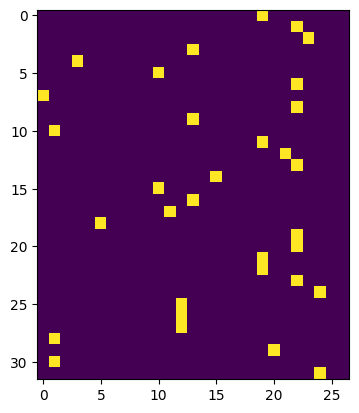

In [321]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))
plt.show()


In [322]:
d_logits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * d_logits_maxes  # 32 x 27

compare_gradients('logits', d_logits, logits)


logits          | exact: True  | approximate: True  | maxdiff: 0.0


#### Layer 2

**d_h**, **d_W2**, **d_b2**  

```python
logits = h @ W2 + b2 
```
---
Toy example:

\begin{align*}
  d &= a @ b + c\\\\
  \begin{bmatrix}
    d_{11} & d_{12}\\
    d_{21} & d_{22}
  \end{bmatrix} &=
  \begin{bmatrix}
    a_{11} & a_{12}\\
    a_{21} & a_{22}
  \end{bmatrix} \cdot
  \begin{bmatrix}
      b_{11} & b_{12}\\
      b_{21} & b_{22}
  \end{bmatrix} +
  \begin{bmatrix}
      c_{11} & c_{12}\\
      c_{21} & c_{22}
  \end{bmatrix}\\\\
  &\Rightarrow
  \begin{cases}
    d_{11} &= a_{11}.b_{11} +a_{12}.b_{21} + c_1\\
    d_{12} &= a_{11}.b_{12} +a_{12}.b_{22} + c_2\\
    d_{21} &= a_{21}.b_{11} +a_{22}.b_{21} + c_1\\
    d_{22} &= a_{21}.b_{12} +a_{22}.b_{22} + c_2
  \end{cases}\\\\
\end{align*}


\begin{align*}
\textsf{We can now calculate the derivative of d with respect to a.}&\\
  \begin{cases}
    \large\frac{\delta L}{\delta a_{11}} &= {\large\frac{\delta L}{\delta d_{11}}}.b_{11} + {\large\frac{\delta L}{\delta d_{12}}}.b_{12}\\\\
    \large\frac{\delta L}{\delta a_{12}} &= {\large\frac{\delta L}{\delta d_{11}}}.b_{21} + {\large\frac{\delta L}{\delta d_{12}}}.b_{22}\\\\
    \large\frac{\delta L}{\delta a_{21}} &= {\large\frac{\delta L}{\delta d_{21}}}.b_{11} + {\large\frac{\delta L}{\delta d_{22}}}.b_{12}\\\\
    \large\frac{\delta L}{\delta a_{22}} &= {\large\frac{\delta L}{\delta d_{21}}}.b_{21} + {\large\frac{\delta L}{\delta d_{22}}}.b_{22} 
  \end{cases}\\\\

  \frac{\delta L}{\delta a} =
  \begin{bmatrix}
    \large\frac{\delta L}{\delta a_{11}} & \large\frac{\delta L}{\delta a_{12}}\\\\
    \large\frac{\delta L}{\delta a_{21}} & \large\frac{\delta L}{\delta a_{22}}
  \end{bmatrix} =
  \begin{bmatrix}
    \large\frac{\delta L}{\delta d_{11}} & \large\frac{\delta L}{\delta d_{12}}\\\\
    \large\frac{\delta L}{\delta d_{21}} & \large\frac{\delta L}{\delta d_{22}}
  \end{bmatrix} \cdot
  \begin{bmatrix}
    b_{11} & b_{21}\\
    b_{12} & b_{22}
  \end{bmatrix} &=

  \begin{bmatrix}
    \large\frac{\delta L}{\delta d_{11}} & \large\frac{\delta L}{\delta d_{12}}\\\\
    \large\frac{\delta L}{\delta d_{21}} & \large\frac{\delta L}{\delta d_{22}}
  \end{bmatrix} \cdot
  \begin{bmatrix}
    b_{11} & b_{12}\\
    b_{21} & b_{22}
  \end{bmatrix}^T =

  \frac{\delta L}{\delta d} \cdot b^T\\\\

  \textsf{Similarly, we can calculate the derivative of d with respect to b.}\\
  \frac{\delta L}{\delta b} = a^T \cdot \frac{\delta L}{\delta d}\\\\

  \textsf{And the derivative of d with respect to c.}\\
  \begin{cases}
    \large\frac{\delta L}{\delta c_1} &= {\large\frac{\delta L}{\delta d_{11}}}.1 + {\large\frac{\delta L}{\delta d_{21}}}.1\\\\
    \large\frac{\delta L}{\delta c_2} &= {\large\frac{\delta L}{\delta d_{12}}}.1 + {\large\frac{\delta L}{\delta d_{22}}}.1
  \end{cases}\\\\
  \frac{\delta L}{\delta c} = \frac{\delta L}{\delta d}\textsf{.sum(axis=0)}\\\\

\end{align*}

---


`h` is a 32 x 64 tensor, `W2` is a 64 x 27 tensor and `b2` is 27d vector. The bias `b2` is broadcasted to a 32 x 27 tensor (`h @ W2`). Internally, the broadcasting is done by casting the 27d vector to a 1 x 27 tensor and then replicating it vertically to a 32 x 27 tensor. 

```{note}
It's not realy necessary to remember the formula's for the derivatives of the linear transformation. The dimensions of the tensors will tell how to calculate the derivatives.

Example:
To calculate `d_h`. The shape of `d_h` is equal to the shape of `h`. It's 32 x 64. We also know that `d_h` should be some matrix multiplication of `d_logits` and `W2`. The shape of `d_logits` is 32 x 27 and the shape of `W2` is 64 x 27. So we can conclude that `d_h = d_logits @ W2.T`.  

The shape of `d_W2` is equal to the shape of `W2`. It's 64 x 27. We also know that `d_W2` should be some matrix multiplication of `h.T` and `d_logits`. The shape of `h.T` is 64 x 32 and the shape of `d_logits` is 32 x 27. So we can conclude that `d_W2 = h.T @ d_logits`.

The shape of `d_b2` is equal to the shape of `b2`. It's 27. We also know that `d_b2` should be the sum of `d_logits` along axis 0. The shape of `d_logits` is 32 x 27. So we can conclude that `d_b2 = d_logits.sum(axis=0)`.

```


In [323]:
d_h = d_logits @ W2.T  # 32 x 64
d_W2 = h.T @ d_logits  # 64 x 27
d_b2 = d_logits.sum(0, keepdims=True)  # 1 x 27

compare_gradients('h', d_h, h)
compare_gradients('W2', d_W2, W2)
compare_gradients('b2', d_b2, b2)


h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


#### Layer 1

##### Non-linearity

**d_h_pre_act**   

```python
h = torch.tanh(h_pre_act)
```

${\large\frac{d}{dx}}\text{tanh}(x) = 1 - \text{tanh}^2(x)$




In [324]:
d_h_pre_act = (1.0 - h**2) * d_h  # 32 x 64

compare_gradients('h_pre_act', d_h_pre_act, h_pre_act)

h_pre_act       | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


##### Batch norm

**d_bn_gain**, **d_bn_raw**, **d_bn_bias**

```python
h_pre_act = bn_gain * bn_raw + bn_bias
```
`bn_gain` and `bn_bias` are 1 x 64 tensors. `bn_raw` and `h_pre_act` are 32 x 64 tensors.  

In [325]:
d_bn_gain = (bn_raw * d_h_pre_act).sum(0, keepdims=True)  # 1 x 64
d_bn_raw = bn_gain * d_h_pre_act  # 32 x 64
d_bn_bias = d_h_pre_act.sum(0, keepdims=True)  # 1 x 64

compare_gradients('bn_gain', d_bn_gain, bn_gain)
compare_gradients('bn_raw', d_bn_raw, bn_raw)
compare_gradients('bn_bias', d_bn_bias, bn_bias)

bn_gain         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bn_raw          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bn_bias         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


**d_bn_diff** - branch 1, **d_bn_var_inv**

```python
bn_raw = bn_diff * bn_var_inv
```
`bn_diff` and `bn_raw` are 32 x 64 tensors, `bn_var_inv` is a 1 x 64 tensor.

In [326]:
d_bn_diff = bn_var_inv * d_bn_raw  # 32 x 64
d_bn_var_inv = (bn_diff * d_bn_raw).sum(0, keepdims=True)  # 1 x 64

compare_gradients('bn_var_inv', d_bn_var_inv, bn_var_inv)


bn_var_inv      | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09


**d_bn_var**
    
```python
bn_var_inv = (bn_var + 1e-5) ** -0.5 
```
$\large\frac{d}{dx}\frac{1}{\sqrt(x)} = -\frac{1}{2x^{3/2}}$

`bn_var_inv` and `bn_var` are 1 x 64 tensors.

In [327]:
d_bn_var = -0.5 * ((bn_var + 1e-5) ** (-3 / 2)) * d_bn_var_inv  # 1 x 64

compare_gradients('bn_var', d_bn_var, bn_var)


bn_var          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


**d_bn_diff2**
    
```python
bn_var = bn_diff2.sum(0, keepdim=True) / (bs - 1)
```

---
Toy example:

\begin{align*}
  \begin{bmatrix}
    a_{11} & a_{12}\\
    a_{21} & a_{22}
  \end{bmatrix} ->
  \begin{bmatrix}
    b_1 & b_2
  \end{bmatrix} =
  \begin{bmatrix}
    (a_{11} + a_{12})/(bs-1) &  (a_{21} + a_{22})/(bs-1)
  \end{bmatrix}
\end{align*}

---

`bn_diff2` is a 32 x 64 tensor, `bn_var` is a 1 x 64 tensor.
The tensor `bn_diff2` is summed in the forward pass, therefore we have to replicate the gradients in the backward pass.

In [328]:
d_bn_diff2 = torch.ones_like(bn_diff2) / (bs - 1) * d_bn_var  # 1 x 64

compare_gradients('bn_diff2', d_bn_diff2, bn_diff2)

bn_diff2        | exact: False | approximate: True  | maxdiff: 2.9103830456733704e-11


**d_bn_diff** - branch 2

```python
bn_diff2 = bn_diff**2
```
${\large\frac{d}{dx}}x^2 = 2x$

`bn_diff2` and `bn_diff` are 32 x 64 tensors. 

In [329]:
d_bn_diff += 2.0 * bn_diff * d_bn_diff2  # 32 x 64

compare_gradients('bn_diff', d_bn_diff, bn_diff)


bn_diff         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10



```python
bn_diff = h_pre_bn - bn_mean_i
```

**d_h_pre_bn** - branch 1, **d_bn_mean_i**

```python
bn_diff = h_pre_bn - bn_mean_i
```
`bn_diff` and `h_pre_bn` are 32 x 64 tensors. `bn_mean_i` is a 1 x 64 tensor.

In [330]:
d_h_pre_bn = d_bn_diff.clone()  # 32 x 64
d_bn_mean_i = -d_bn_diff.sum(0, keepdims=True)  # 1 x 64

compare_gradients('bn_mean_i', d_bn_mean_i, bn_mean_i)


bn_mean_i       | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


**d_h_pre_bn** - branch 2 
```python
bn_mean_i = h_pre_bn.sum(0, keepdim=True) / bs 
```
`bn_mean_i` is a 1 x 64 tensor, `h_pre_bn` is a 32 x 64 tensor.

In [331]:
d_h_pre_bn += torch.ones_like(h_pre_bn) / bs * d_bn_mean_i  # 32 x 64

compare_gradients('h_pre_bn', d_h_pre_bn, h_pre_bn)


h_pre_bn        | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


##### Pre-batch norm

**d_emb_cat**, **d_W1**, **d_b1**

```python
h_pre_bn = emb_cat @ W1 + b1
```
`h_pre_bn` and `emb_cat` are 32 x 64 tensors, `W1` is a 30 x 64 tensor and `b1` is a 64d vector.

In [332]:
d_emb_cat = d_h_pre_bn @ W1.T  # 32 x 30
d_W1 = emb_cat.T @ d_h_pre_bn  # 30 x 64
d_b1 = d_h_pre_bn.sum(0)  # 64

compare_gradients('emb_cat', d_emb_cat, emb_cat)
compare_gradients('W1', d_W1, W1)
compare_gradients('b1', d_b1, b1)

emb_cat         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
W1              | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
b1              | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09


### Embedding layer

**d_emb**

```python
emb_cat = emb.view(emb.shape[0], -1)
```
`emb_cat` is a 32 x 30 tensor, `emb` is a 32 x 3 x 10 tensor.

In [333]:
d_emb = d_emb_cat.view(emb.shape)  # 32 x 3 x 10

compare_gradients('emb', d_emb, emb)


emb             | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


**d_C**

```python
emb = C[Xb]
```
`emb` is a 32 x 3 x 10 tensor, `C` is a 27 x 10 tensor and `Xb` is a 32 x 3 tensor.

Each element of `Xb` a character index. Each character index is used to select a row (10d vector) from `C`.  
We can calculate the backward pass in different ways.   
- Naive: we first create a zero tensor `d_C` with the same shape as `C` (27 x 10). Then we loop over the 32 samples from `Xb`. For each sample, we loop over the 3 character indices. For each character index, we add the corresponding 10d vector from `d_emb` to the corresponding row in `d_C`.   

- Vectorised 1: we first transform each element of `Xb` into a 27d one-hot vector. `Xb_1_hot` is then a 32 x 3 x 27 tensor with 32 samples, each having 3 one-hot vectors. We then reshape `Xb_1_hot` into a (32x3) x 27 tensor and `d_emb` into a (32x3) x 10 tensor. Then `d_C = Xb_1_hot @ d_emb`, which is a 27 x 10 tensor.

- Vectorised 2: We can take the dot product of 'Xb_1_hot' and 'd_emb' using [torch.tensordot](https://pytorch.org/docs/stable/generated/torch.tensordot.html). 

- Vectorised 3: We can use [torch.einsum](https://pytorch.org/docs/stable/generated/torch.einsum.html).





In [334]:
# Naive implementation 1
d_C = torch.zeros_like(C)  # 27 x 10
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i, j]
        d_C[ix] += d_emb[i, j]

compare_gradients('C', d_C, C)


C               | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [335]:
# Vectorized implementation 1
one_hot_Xb = F.one_hot(Xb, 27).view((-1, 27)).float()  # 32 x 3 x 27
d_C = one_hot_Xb.T @ d_emb.view(-1, 10)  # 27 x 10

compare_gradients('C', d_C, C)

C               | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [336]:
# Vectorized implementation 2
Xb_1hot = F.one_hot(Xb, vocab_size).float()  # 32 x 3 x 27
d_C = torch.tensordot(Xb_1hot, d_emb, dims=([0, 1], [0, 1]))  # type: ignore 27 x 10

compare_gradients('C', d_C, C)

C               | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [337]:
# Vectorized implementation 3
Xb_1hot = F.one_hot(Xb, vocab_size).float()  # 32 x 3 x 27
d_C = torch.einsum('ijk,ijl->kl', Xb_1hot, d_emb)  #  27 x 10

compare_gradients('C', d_C, C)

C               | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


## Backpropagation through cross entropy loss

In the previous sections we calculated the cross entropy loss in very small atomic steps and we backpropagated through each step.


```python
# Cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values  
norm_logits = logits - logit_maxes 
counts = norm_logits.exp()  
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1  
probs = counts * counts_sum_inv  
logprobs = probs.log()  
loss = -logprobs[range(bs), Yb].mean()
```
In this section we will calculate the cross entropy loss in one step by using [F.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) and manually backpropagate through it. 


In [338]:
loss_fast = F.cross_entropy(logits, Yb)
print(f"loss_fast: {loss_fast.item():.4f}, loss: {loss.item():.4f}, diff: {(loss_fast - loss).item():.4f}")


loss_fast: 3.4002, loss: 3.4002, diff: 0.0000


`loss_fast` is much faster thant the previous `loss`.

In [339]:
%%timeit
logit_maxes = logits.max(1, keepdim=True).values  
norm_logits = logits - logit_maxes 
counts = norm_logits.exp()  
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1  
probs = counts * counts_sum_inv  
logprobs = probs.log()  
loss = -logprobs[range(bs), Yb].mean()

115 µs ± 627 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [340]:
%%timeit
F.cross_entropy(logits, Yb)

17.1 µs ± 687 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Backward pass

We will derive the mathematical expressions for calculatind `d_logits` in one step.

```python
loss_fast = F.cross_entropy(logits, Yb)
```


![cross_entropy_diag](./media/cross_entropy_diag.png)


For a single sample, the cross entropy loss is calculated as follows:

\begin{align*}
loss &= -log (p_y)\\
p_i &= \frac{e^{l_i}}{\sum_j e^{l_j}}\\
\Rightarrow loss &= -log\frac{e^{l_y}}{\sum_j e^{l_j}}
\end{align*}
where $p$ is a vector of all probablilties, $p_y$ are the probabilities of the label (character) $y$, $p_i$ are the probabilities of the $i$-th sample and $l_i$ the logit of the $i$-th sample.

The derivative of the cross entropy loss with respect to the $i$-th logit is: 

\begin{align*}
\frac{d}{dl_i}loss = \frac{d}{dl_i}(-log\frac{e^{l_y}}{\sum_j e^{l_j}})\\
\end{align*}
using ${\large\frac{d}{dx}}log(x) =\large\frac{1}{x}$  
\begin{align*}
& = -\frac{\sum_j e^{l_j}}{e^{l_y}}\frac{d}{dl_i}(\frac{e^{l_y}}{\sum_j e^{l_j}}) \\
& = -\frac{\sum_j{e^{l_j}}}{e^{l_y}} {\left[\frac{e^{l_y}}{\sum_j e^{l_j}} -\frac{e^{l_y}e^{l_i}}{(\sum_j e^{l_j})^2} \right]}\\
\end{align*}

if $i \neq y$:

\begin{align*}
& =\frac{\sum_j{e^{l_j}}}{e^{l_y}} {\left[0 + \frac{e^{l_y}e^{l_i}}{(\sum_j{e^{l_j}})^2}  \right]}\\
& =\frac{e^{l_i}}{\sum_j{e^{l_j}}}\\
& =p_i
\end{align*}

if $i = y$:

\begin{align*}
& = -{\left[ 1-\frac{e^{l_i}}{\sum_j{e^{l_j}}} \right]}\\
& = \frac{e^{l_i}}{\sum_j{e^{l_j}}} - 1\\
& = p_i - 1

\end{align*}

The gradient is either the softmax ($p_i$) or the softmax minus 1 ($p_i-1$) depending on whether the logit .   
This is the gradient of a single sample $i$. The loss of a batch is the average of the losses of all samples in the batch. We have to backpropagate through the average as well. The gradient of the average is $\large\frac{1}{bs}$.




In [341]:
d_logits = F.softmax(logits, dim=1)  # 32 x 27
# substract 1 from the correct class
d_logits[range(bs), Yb] -= 1.0
# backprop through averaging
d_logits /= bs

compare_gradients('logits', d_logits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


### Intuition of cross-entropy loss

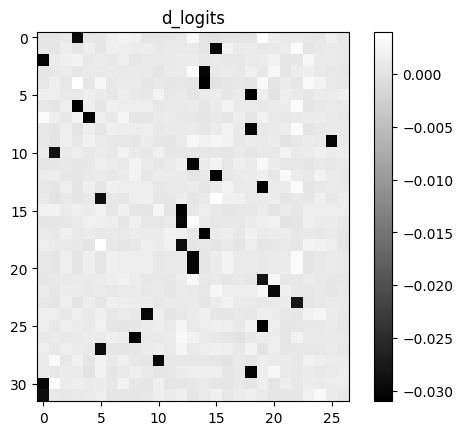

In [342]:
plt.imshow(d_logits.detach(), cmap='gray')
plt.colorbar()
plt.title('d_logits')
plt.show()

The black `d_logits` squares are the position of the correct indices where we substracted 1 from the gradient. The other squares are the positions where `d_logits * bs` is equal to the probability.

Let's look at 1 sample:

In [343]:
s = 0
print(f"y:        {Yb[s]}")
print(f"probs:    {F.softmax(logits, dim=1)[s]}")
print(f"d_logits: {d_logits[0]*bs}")
print(f"diff:     {F.softmax(logits, dim=1)[s] - d_logits[s]*bs}")

y:        3
probs:    tensor([0.0169, 0.0170, 0.0293, 0.0593, 0.0290, 0.0248, 0.0547, 0.0782, 0.0586, 0.0179, 0.0154, 0.0233, 0.0286, 0.1021,
        0.0118, 0.0096, 0.0166, 0.0185, 0.0146, 0.1269, 0.0520, 0.0301, 0.0391, 0.0276, 0.0204, 0.0548, 0.0231],
       grad_fn=<SelectBackward0>)
d_logits: tensor([ 0.0169,  0.0170,  0.0293, -0.9407,  0.0290,  0.0248,  0.0547,  0.0782,  0.0586,  0.0179,  0.0154,  0.0233,
         0.0286,  0.1021,  0.0118,  0.0096,  0.0166,  0.0185,  0.0146,  0.1269,  0.0520,  0.0301,  0.0391,  0.0276,
         0.0204,  0.0548,  0.0231], grad_fn=<MulBackward0>)
diff:     tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SubBackward0>)


`probs` sums to 1, `d_logits` sums to 0. This is logic because `d_logits` is equal to `probs` except in exactly one place where we substracted 1 . 

In [344]:
print(f"sum of probs: {F.softmax(logits, dim=1)[s].sum()}")
print(f"sum of d_logits: {d_logits[s].sum()}")


sum of probs: 1.0
sum of d_logits: -9.313225746154785e-10


```{note}
The intuition is to think about the `d_logits` gradients of each sample as a force that pushes the logits up for position corresponding to the correct label and pushes the logits down for all other positions. The total amount of force is 0 because the sum of the gradients is 0.  
The amount of force that we are applying to each position is proportional to the probability of that position. If the probabilities are exactly correct then the force that we apply to each position is 0.  The `probs` is 0 everywhere except for the correct position where it is 1. `d_logits` is 0 everywhere. If we have a confidently mispredicted element then the `probs` is ~0 everywhere except for the mispredicted position where it is ~1. `d_logits` is ~0 everywhere except for the mispredicted position where it is ~-1 and ~1 for the correct position. The force applied to the mispredicted position pulls that logit down and the equal force is applied to the correct position and pushes that logit up. 
```

In [345]:
# Exacly correct
y = 3
print(f"y:             {y}")
probs_ = torch.zeros_like(logits)
probs_[0, y] = 1.0
print(f"probs:         {probs_[0]}")
d_logits_ = probs_.clone()
d_logits_[0, y] -= 1.0
print(f"d_logits:      {d_logits_[0]}")
print(f"probs_updated: {probs_[0] - d_logits_[0]}")

y:             3
probs:         tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
d_logits:      tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
probs_updated: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [346]:
# Confidently wrong
y = 3
print(f"y:             {y}")
probs_ = torch.zeros_like(logits)
probs_[0, 0] = 1.0  # confident wrong predicting 0
print(f"probs:         {probs_[0]}")
d_logits_ = probs_.clone()
d_logits_[0, y] -= 1.0
print(f"d_logits:      {d_logits_[0]}")
print(f"probs_updated: {probs_[0] - d_logits_[0]}")

y:             3
probs:         tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
d_logits:      tensor([ 1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.])
probs_updated: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


## Backpropagation through batchnorm

In the previous sections we calculated the batchnorm in very small atomic steps and we backpropagated through each step.

```python
# batchnorm
bn_mean_i = h_pre_bn.sum(0, keepdim=True) / bs  
bn_diff = h_pre_bn - bn_mean_i  
bn_diff2 = bn_diff**2  
bn_var = bn_diff2.sum(0, keepdim=True) / (bs - 1)
bn_var_inv = (bn_var + 1e-5) ** -0.5
bn_raw = bn_diff * bn_var_inv  
h_pre_act = bn_gain * bn_raw + bn_bias
```

In this section we will calculate the batchnorm in one step by using the formula $y_i=\gamma{\large\frac{x_i-\mu}{\sqrt{\sigma^2+\epsilon}}} + \beta$ and manually backpropagate through it.

In [347]:
h_pre_act_fast = (
    bn_gain
    * (h_pre_bn - h_pre_bn.mean(0, keepdim=True))
    / torch.sqrt(h_pre_bn.var(0, keepdim=True, unbiased=True) + 1e-5)
    + bn_bias
)
print('max diff:', (h_pre_act_fast - h_pre_act).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


### Backward pass

We will derive the mathematical expressions for calculating `d_h_pre_bn` in one step. 

```python
h_pre_act_fast &= bn_gain*(h_pre_bn - h_pre_bn.mean(0, keepdim&=True)) / torch.sqrt(h_pre_bn.var(0, keepdim&=True, unbiased&=True) + 1e-5) + bn_bias
```

![batchnorm_diag](./media/batchnorm_diag.png)


$\mu = \frac{1}{m}\sum_{i}^{m}x_i\\$
$\sigma^2 = \frac{1}{m-1}\sum_{i}^{m}(x_i-\mu)^2\\$
$\hat{x_i} = \frac{x_i-\mu}{\sqrt{\sigma^2+\epsilon}}\\$
$y_i = \gamma\hat{x_i} + \beta\\$

We have $\large\frac{\delta L}{\delta y_1}\\$  
We want $\large\frac{\delta L}{\delta x_1}\\$

(1)

\begin{align*}
  \frac{\delta L}{\delta \hat{x_i}} &= \frac{\delta L}{\delta y_i}*\gamma
\end{align*}

(2)   
The $i$ components of $\hat x$ are dependent on $\sigma$ in the forward pass. Therefore we have to sum over all $i$'s in the backward pass.
  
\begin{align*}
  \frac{\delta L}{\delta \sigma^2} &= \sum_{i}\frac{\delta \hat{x_i}}{\delta \sigma^2}\frac{\delta L}{\delta \hat{x_i}}\\ 
  &= \gamma*\sum_{i}\frac{\delta}{\delta \sigma^2}\left[\frac{x_i-\mu}{\sqrt{\sigma^2+\epsilon}}\right]\frac{\delta L}{\delta y_i}\\
  &= -\frac{1}{2}*\gamma*\sum_{i}\frac{\delta}{\delta y_i}{\left[\frac{x_i-\mu}{(\sigma^2+\epsilon)^{\frac{3}{2}}}\right]}\\
  \end{align*}

(3)   
The $i$ components of $\hat x$ are dependent on $\mu$ in the forward pass. Therefore we have to sum over all $i$'s in the backward pass. Additionally we $\sigma$ is dependent on $\mu$ and therefore we also have to add the gradient of $\sigma$ with respect to $\mu$.

\begin{align*}
  \frac{\delta L}{\delta \mu} &= \sum_{i}\frac{\delta \hat{x_i}}{\delta \mu}\frac{\delta L}{\delta \hat{x_i}} + \frac{\delta \sigma^2}{\delta \mu}\frac{\delta L}{\delta \sigma^2}\\\\
  \frac{\delta\hat{x_i}}{\delta \mu} &= \frac{\delta}{\delta \mu}\left[\frac{x_i-\mu}{\sqrt{\sigma^2+\epsilon}}\right]\\
  &= -\frac{1}{\sqrt{\sigma^2+\epsilon}}\\\\
  \frac{\delta\sigma^2}{\delta \mu} &= \frac{\delta}{\delta \mu}\left[\frac{1}{m-1}\sum_{i}(x_i-\mu)^2\right]\\
  &= \frac{-2}{m-1}\sum_{i}(x_i-\mu)\\\\
  &= \frac{-2}{m-1}\sum_{i}x_i -\sum_{i}-\mu\\
  &= \frac{-2}{m-1}\left[m\mu -m\mu\right] \quad(\textsf{because }\small\mu=\frac{1}{m}\sum_{i}x_i)\\
  &= 0\\\\
  \Rightarrow  \frac{\delta L}{\delta \mu} &= -\frac{\gamma}{\sqrt{\sigma^2+\epsilon}}\sum_{i}\frac{\delta L}{\delta y_i} + 0\\
\end{align*}
  
(4)

\begin{align*}
\frac{\delta L}{\delta x_i} &= \frac{\delta \hat{x_i}}{\delta x_i}\frac{\delta L}{\delta \hat{x_i}} + \frac{\delta \mu}{\delta x_i}\frac{\delta L}{\delta \mu} + \frac{\delta \sigma^2}{\delta x_i}\frac{\delta L}{\delta \sigma^2}\\\\
\frac{\delta \hat{x_i}}{\delta x_i} &= \frac{\delta}{\delta x_i}\left[\frac{x_i-\mu}{\sqrt{\sigma^2+\epsilon}}\right]\\
&= \frac{1}{\sqrt{\sigma^2+\epsilon}}\\\\
\frac{\delta \mu}{\delta x_i} &= \frac{\delta}{\delta x_i}\left[\frac{1}{m}\sum_{i}x_i\right]\\
&= \frac{1}{m}\\\\
\frac{\delta \sigma^2}{\delta x_i} &= \frac{\delta}{\delta x_i}\left[\frac{1}{m-1}\sum_{i}(x_i-\mu)^2\right]\\
&= \frac{2}{m-1}(x_i-\mu)\\\\

\Rightarrow\frac{\delta L}{\delta x_i} &= \frac{1}{\sqrt{\sigma^2+\epsilon}}\frac{\delta L}{\delta \hat{y_i}}*\gamma + \left[-\frac{1}{m}\frac{\gamma}{\sqrt{\sigma^2+\epsilon}}\sum_{j}\frac{\delta L}{\delta y_j}\right] + \left[\frac{2}{m-1}(x_i-\mu)\right]\left[-\frac{1}{2}\gamma\sum_{j}\frac{\delta L}{\delta y_j}\frac{x_j-\mu}{(\sigma^2+\epsilon)^{\frac{3}{2}}}\right]\\
&= \frac{1}{\sqrt{\sigma^2+\epsilon}}\frac{\delta L}{\delta \hat{y_i}}*\gamma - \left[\frac{1}{m}\frac{\gamma}{\sqrt{\sigma^2+\epsilon}}\sum_{j}\frac{\delta L}{\delta y_j}\right] - \left[\frac{1}{m-1}\frac{x_i-\mu}{\sqrt{\sigma^2+\epsilon}}\right]\left[\frac{\gamma}{\sqrt{\sigma^2+\epsilon}}\sum_{j}\frac{\delta L}{\delta y_j}\frac{x_j-\mu}{\sqrt{\sigma^2+\epsilon}}\right]\\
\left(\textsf{because }\small\hat{x_i}=\frac{x_i-\mu}{\sqrt{\sigma^2+\epsilon}}\right)\\
&= \frac{\gamma}{m\sqrt{\sigma^2+\epsilon}}\left[m\frac{\delta L}{\delta y_i}-\sum_{j}\frac{\delta L}{\delta y_j}-\frac{m}{m-1}\hat{x_i}\sum_{j}\frac{\delta L}{\delta y_j}\hat{x_j}\right]\\
\end{align*}

The formula for $\large\frac{\delta L}{\delta x_i}$ is for a single neuron and a batch of 32 samples. 


In [348]:
d_h_pre_bn = (
    bn_gain
    * bn_var_inv
    / bs
    * (bs * d_h_pre_act - d_h_pre_act.sum(0) - bs / (bs - 1) * bn_raw * (d_h_pre_act * bn_raw).sum(0))
)

compare_gradients('h_pre_bn', d_h_pre_bn, h_pre_bn)

h_pre_bn        | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


## Train the MLP model with manual backpropagation

We will now train our MLP model with the manual backpropagation algorithm. 

**Model**

In [349]:
n_emb = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(seed)  # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)

# Layer 1
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5 / 3) / ((n_emb * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
bn_gain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bn_bias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
n_params = sum(p.nelement() for p in parameters)
print(f'Total # parameters: {n_params:,}')
for p in parameters:
    p.requires_grad = True



Total # parameters: 4,137


**Training**

In [350]:
# same optimization as last time
max_steps = 200000
bs = 32
loss_i = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
    # kick off optimization
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (bs,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

        # forward pass
        emb = C[Xb]  # embed the characters into vectors
        emb_cat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        # Linear layer
        h_pre_bn = emb_cat @ W1 + b1  # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bn_mean = h_pre_bn.mean(0, keepdim=True)
        bn_var = h_pre_bn.var(0, keepdim=True, unbiased=True)
        bn_var_inv = (bn_var + 1e-5) ** -0.5
        bn_raw = (h_pre_bn - bn_mean) * bn_var_inv
        h_pre_act = bn_gain * bn_raw + bn_bias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(h_pre_act)  # hidden layer
        logits = h @ W2 + b2  # output layer
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop!
        # -----------------
        d_logits = F.softmax(logits, 1)
        d_logits[range(bs), Yb] -= 1
        d_logits /= bs
        # 2nd layer backprop
        d_h = d_logits @ W2.T
        d_W2 = h.T @ d_logits
        d_b2 = d_logits.sum(0)
        # tanh
        d_h_pre_act = (1.0 - h**2) * d_h
        # batchnorm backprop
        d_bn_gain = (bn_raw * d_h_pre_act).sum(0, keepdim=True)
        d_bn_bias = d_h_pre_act.sum(0, keepdim=True)
        d_h_pre_bn = bn_gain * bn_var_inv / bs * (bs * d_h_pre_act - d_h_pre_act.sum(0) - bs / (bs - 1) * bn_raw * (d_h_pre_act * bn_raw).sum(0))
        # 1st layer
        d_emb_cat = d_h_pre_bn @ W1.T
        d_W1 = emb_cat.T @ d_h_pre_bn
        d_b1 = d_h_pre_bn.sum(0)
        # embedding
        d_emb = d_emb_cat.view(emb.shape)
        d_C = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                d_C[ix] += d_emb[k, j]
        grads = [d_C, d_W1, d_b1, d_W2, d_b2, d_bn_gain, d_bn_bias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
        for p, grad in zip(parameters, grads): # type: ignore
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad  # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0:  # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        loss_i.append(loss.log10().item())


      0/ 200000: 3.3884
  10000/ 200000: 2.4541
  20000/ 200000: 2.4857
  30000/ 200000: 2.1198
  40000/ 200000: 2.3114
  50000/ 200000: 1.9466
  60000/ 200000: 2.5517
  70000/ 200000: 2.2360
  80000/ 200000: 1.9703
  90000/ 200000: 2.2679
 100000/ 200000: 2.3220
 110000/ 200000: 1.6446
 120000/ 200000: 2.2917
 130000/ 200000: 2.1344
 140000/ 200000: 2.2928
 150000/ 200000: 1.8781
 160000/ 200000: 2.2685
 170000/ 200000: 2.2070
 180000/ 200000: 1.9090
 190000/ 200000: 1.8184


**Calibrate the batch norm**

In [351]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


**Evaluate train and val loss**

In [352]:


@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h_pre_act = emb_cat @ W1 + b1
  h_pre_act = bn_gain * (h_pre_act - bnmean) * (bnvar + 1e-5)**-0.5 + bn_bias
  h = torch.tanh(h_pre_act) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1481568813323975
val 2.157963275909424


In [353]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      h_pre_act = emb_cat @ W1 + b1
      h_pre_act = bn_gain * (h_pre_act - bnmean) * (bnvar + 1e-5)**-0.5 + bn_bias
      h = torch.tanh(h_pre_act) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(ix2ch[i] for i in out))

mora.
kayanniee.
madhayla.
renyastendra.
gradered.
eliah.
miloe.
leigh.
van.
aar.
kayzioh.
kalin.
shabergahiriel.
kindreelynn.
novalayubelynder.
yah.
fael.
yuma.
myston.
azhil.
